# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch K=4 to K=3.

In [120]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 15:59:32.718890
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [121]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=3
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [122]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [123]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [124]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [125]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [126]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 15:59:35.049313
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 15:59:35.083378
Load sequence...
2022-12-29 15:59:46.286755
Num IDs: 6935
Example IDs: [('ENSG00000197530', 'ENST00000505820.7'), ('ENSG00000149527', 'ENST00000278878.6'), ('ENSG00000171680', 'ENST00000535355.6'), ('ENSG00000171680', 'ENST00000537245.6')]
Count 2965 ones out of 6935 labels.
Example labels: [0, 0, 0, 0]
Num counts: 6935
Example sequence: [52, 13, 49, 1, 4, 15, 58, 40, 32, 62, 56, 30, 53, 20, 14, 53, 19, 9, 34, 8, 30, 53, 17, 3, 11, 42, 38, 24, 31, 57, 35, 11, 44, 47, 57, 36, 15, 58, 40, 31, 57, 36, 15, 58, 40, 31, 60, 47, 58, 38, 24, 31, 57, 33, 4, 16, 62, 54, 21, 19, 10, 37, 19, 11, 43, 41, 35, 11, 41, 35, 11, 42, 37, 20, 15, 57, 35, 11, 44, 47, 58, 39, 28, 46, 54, 23, 25, 34, 8, 30, 54, 22, 24, 32, 62, 54, 22, 21, 20, 14, 53, 18, 5, 19, 10, 40, 31, 57, 35, 10, 40, 29, 51, 12, 48, 6

## Model

In [127]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [128]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 15:59:46.327953
COMPILE
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_61 (Embedding)    (None, 3998, 4)           260       
                                                                 
 conv1d_61 (Conv1D)          (None, 3991, 64)          2112      
                                                                 
 global_average_pooling1d_48  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_121 (Dense)           (None, 1)                 65        
                                                                 
Total params: 2,437
Trainable params: 2,437
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [129]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 15:59:46.607623
2022-12-29 15:59:46.607783
splitting
Fold 1
Training example
[42 39 27 ...  0  0  0]
Train sizes (5543, 3998) (5543, 1)
Valid sizes (1392, 3998) (1392, 1)
Train set ones/size 2391 / 5543
Valid set ones/size 574 / 1392
BUILD MODEL
COMPILE
FIT
2022-12-29 15:59:48.305924
Epoch 1/5
174/174 [==============================] - 2s 9ms/step - loss: 0.5893 - accuracy: 0.6662 - val_loss: 0.5499 - val_accuracy: 0.7134
Epoch 2/5
174/174 [==============================] - 1s 7ms/step - loss: 0.5137 - accuracy: 0.7485 - val_loss: 0.5445 - val_accuracy: 0.7141
Epoch 3/5
174/174 [==============================] - 1s 7ms/step - loss: 0.5087 - accuracy: 0.7501 - val_loss: 0.5404 - val_accuracy: 0.7177
Epoch 4/5
174/174 [==============================] - 1s 7ms/step - loss: 0.5036 - accuracy: 0.7577 - val_loss: 0.5536 - val_accuracy: 0.7011
Epoch 5/5
174/174 [==============================] - 1s 7ms/step - loss: 0.5026 - accuracy: 0.7566 - val_loss: 0.5341 - val_accuracy: 0.7184

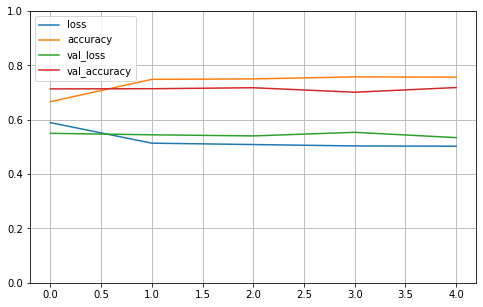

Compute valiation accuracy
2022-12-29 15:59:55.847539
Range of scores: 0.026426032 to 0.9384274
Predicted zeros and ones 790 602
Accuracy: 71.84% Precision: 65.12% Recall: 68.29% F1: 66.67%
2022-12-29 15:59:56.075716
Fold 2
Training example
[42 39 27 ...  0  0  0]
Train sizes (5522, 3998) (5522, 1)
Valid sizes (1413, 3998) (1413, 1)
Train set ones/size 2375 / 5522
Valid set ones/size 590 / 1413
BUILD MODEL
COMPILE
FIT
2022-12-29 15:59:57.719558
Epoch 1/5
173/173 [==============================] - 2s 9ms/step - loss: 0.5983 - accuracy: 0.6673 - val_loss: 0.5100 - val_accuracy: 0.7431
Epoch 2/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5243 - accuracy: 0.7371 - val_loss: 0.5037 - val_accuracy: 0.7495
Epoch 3/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5201 - accuracy: 0.7443 - val_loss: 0.4987 - val_accuracy: 0.7580
Epoch 4/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5175 - accuracy: 0.7390 - val_loss: 0.4918 - val_accu

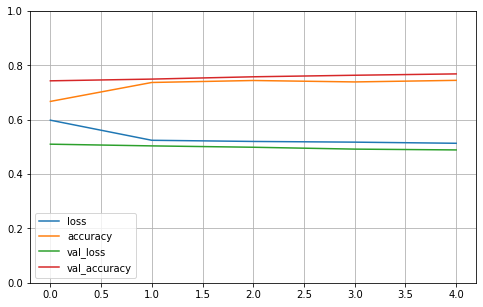

Compute valiation accuracy
2022-12-29 16:00:04.996179
Range of scores: 0.025075931 to 0.949039
Predicted zeros and ones 788 625
Accuracy: 76.86% Precision: 71.04% Recall: 75.25% F1: 73.09%
2022-12-29 16:00:05.232077
Fold 3
Training example
[42 39 27 ...  0  0  0]
Train sizes (5525, 3998) (5525, 1)
Valid sizes (1410, 3998) (1410, 1)
Train set ones/size 2355 / 5525
Valid set ones/size 610 / 1410
BUILD MODEL
COMPILE
FIT
2022-12-29 16:00:06.841357
Epoch 1/5
173/173 [==============================] - 2s 9ms/step - loss: 0.5915 - accuracy: 0.6643 - val_loss: 0.5200 - val_accuracy: 0.7681
Epoch 2/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5196 - accuracy: 0.7374 - val_loss: 0.5148 - val_accuracy: 0.7645
Epoch 3/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5147 - accuracy: 0.7412 - val_loss: 0.5176 - val_accuracy: 0.7652
Epoch 4/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5107 - accuracy: 0.7410 - val_loss: 0.5081 - val_accur

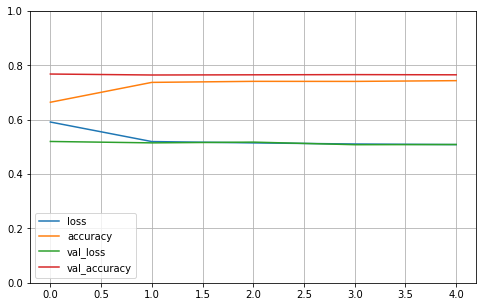

Compute valiation accuracy
2022-12-29 16:00:17.876217
Range of scores: 0.017789388 to 0.9699074
Predicted zeros and ones 761 649
Accuracy: 76.52% Precision: 71.49% Recall: 76.07% F1: 73.71%
2022-12-29 16:00:18.112554
Fold 4
Training example
[42 39 27 ...  0  0  0]
Train sizes (5528, 3998) (5528, 1)
Valid sizes (1407, 3998) (1407, 1)
Train set ones/size 2370 / 5528
Valid set ones/size 595 / 1407
BUILD MODEL
COMPILE
FIT
2022-12-29 16:00:19.819167
Epoch 1/5
173/173 [==============================] - 2s 10ms/step - loss: 0.5979 - accuracy: 0.6681 - val_loss: 0.5249 - val_accuracy: 0.7249
Epoch 2/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5197 - accuracy: 0.7419 - val_loss: 0.5187 - val_accuracy: 0.7328
Epoch 3/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5143 - accuracy: 0.7480 - val_loss: 0.5160 - val_accuracy: 0.7342
Epoch 4/5
173/173 [==============================] - 1s 7ms/step - loss: 0.5104 - accuracy: 0.7493 - val_loss: 0.5228 - val_acc

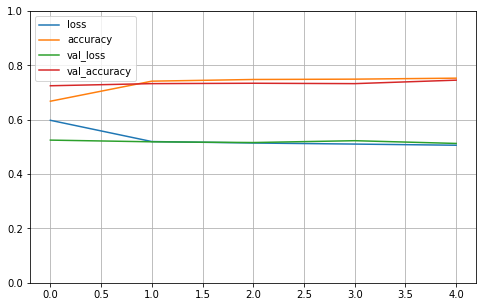

Compute valiation accuracy
2022-12-29 16:00:30.894322
Range of scores: 0.032025382 to 0.95827246
Predicted zeros and ones 766 641
Accuracy: 74.56% Precision: 68.49% Recall: 73.78% F1: 71.04%
2022-12-29 16:00:31.135579
Fold 5
Training example
[24 31 59 ...  0  0  0]
Train sizes (5622, 3998) (5622, 1)
Valid sizes (1313, 3998) (1313, 1)
Train set ones/size 2369 / 5622
Valid set ones/size 596 / 1313
BUILD MODEL
COMPILE
FIT
2022-12-29 16:00:32.840983
Epoch 1/5
176/176 [==============================] - 2s 8ms/step - loss: 0.5850 - accuracy: 0.6754 - val_loss: 0.5131 - val_accuracy: 0.7471
Epoch 2/5
176/176 [==============================] - 1s 7ms/step - loss: 0.5228 - accuracy: 0.7421 - val_loss: 0.5135 - val_accuracy: 0.7532
Epoch 3/5
176/176 [==============================] - 2s 9ms/step - loss: 0.5181 - accuracy: 0.7400 - val_loss: 0.4991 - val_accuracy: 0.7517
Epoch 4/5
176/176 [==============================] - 2s 9ms/step - loss: 0.5124 - accuracy: 0.7481 - val_loss: 0.4978 - val_acc

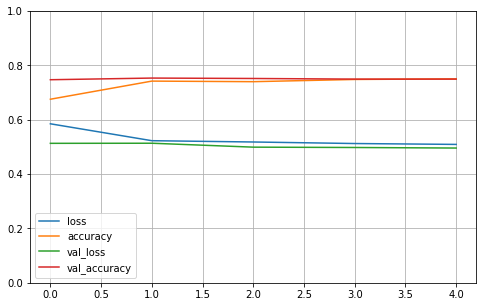

Compute valiation accuracy
2022-12-29 16:00:40.814244
Range of scores: 0.02390647 to 0.94567317
Predicted zeros and ones 756 557
Accuracy: 74.94% Precision: 73.97% Recall: 69.13% F1: 71.47%
2022-12-29 16:00:41.038522

Cross validation 5 folds 5 epochs
 accuracy mean 74.94% +/- 1.79
 precision mean 70.02% +/- 3.01
 recall mean 72.50% +/- 3.19
 F1 mean 71.19% +/- 2.47
2022-12-29 16:00:41.046834


In [130]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())